Successfully loaded 'kalman_filter_results.csv'
Successfully loaded 'xgboost_volatility_model.joblib'
Successfully loaded 'xtest_features.csv'
Starting Beta for simulation (from 2010-01-04): 1.1904
Simulation complete.


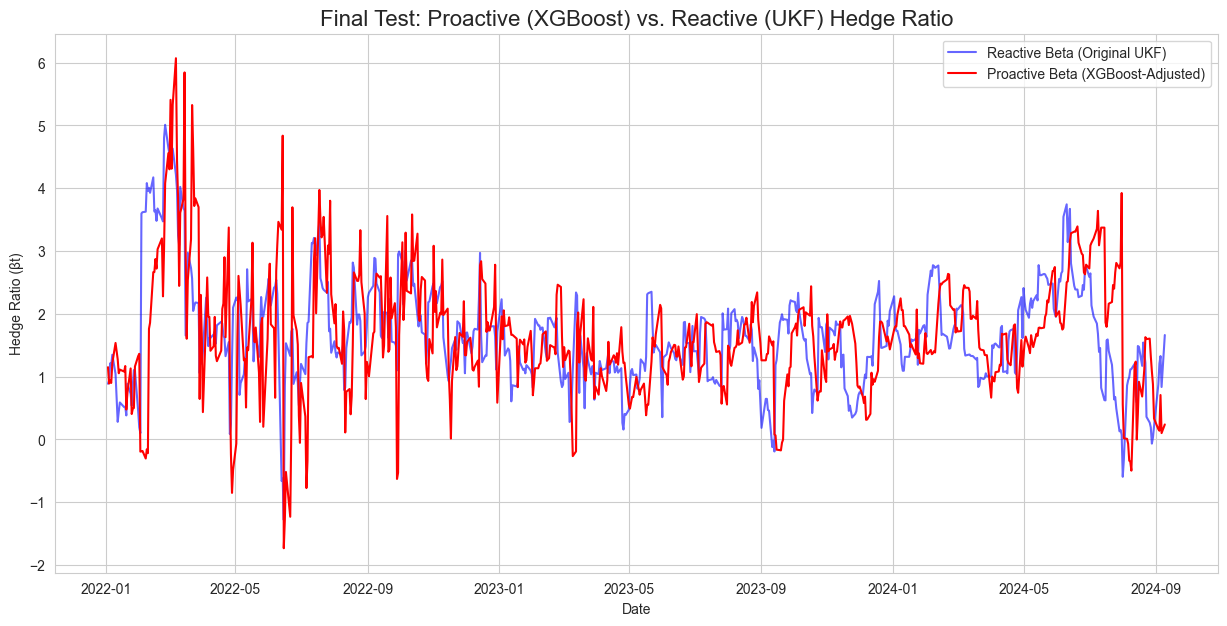

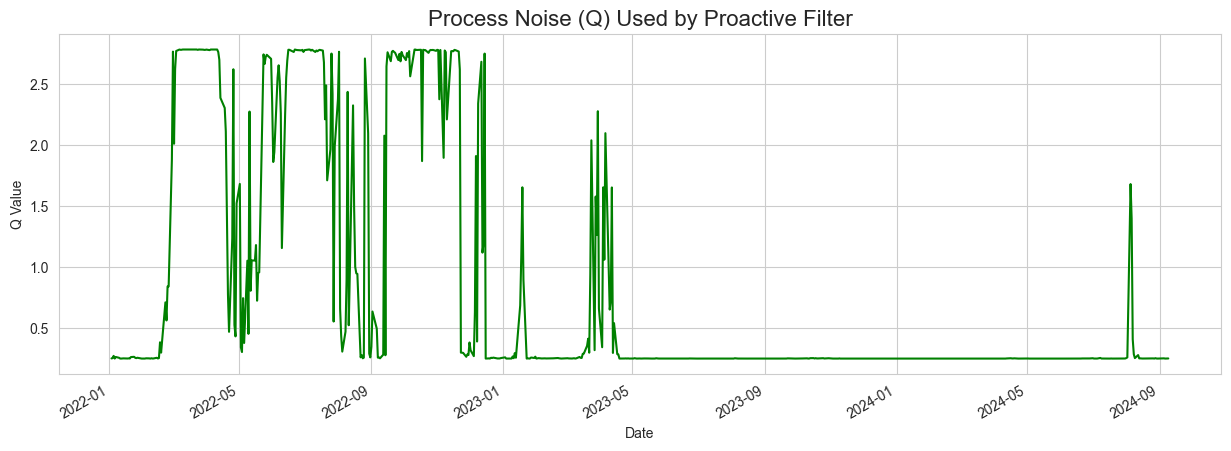

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from pykalman import UnscentedKalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns

path_to_downloads = '/Users/ogizelenovic/Downloads/'
kf_results_file = path_to_downloads + 'kalman_filter_results.csv'
xgboost_model_file = path_to_downloads + 'xgboost_volatility_model.joblib'
xtest_features_file = path_to_downloads + 'xtest_features.csv'

try:
    final_data = pd.read_csv(kf_results_file, index_col='Date', parse_dates=True)
    print("Successfully loaded 'kalman_filter_results.csv'")

    model = joblib.load(xgboost_model_file)
    print("Successfully loaded 'xgboost_volatility_model.joblib'")
    
    X_test = pd.read_csv(xtest_features_file, index_col=0, parse_dates=True)
    print("Successfully loaded 'xtest_features.csv'")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all notebooks have been run and files saved.")
    print(f"Missing file: {e.filename}")

optimal_Q = 0.2533550338856525 
optimal_R = 0.00011846221964561744

split_date = '2022-01-01'

final_data.index = pd.to_datetime(final_data.index) 
last_training_day = final_data.index[final_data.index < split_date][-1]
last_beta_from_training = final_data.loc[last_training_day]['UKF_Beta']

print(f"Starting Beta for simulation (from {last_training_day.date()}): {last_beta_from_training:.4f}")

df_test = final_data.loc[X_test.index].copy()

observations_test = df_test['log returns_y'].values
fx_returns_test = df_test['log returns_x'].values

current_state_mean = np.array([last_beta_from_training])
current_state_covariance = np.array([[1.0]])

proactive_betas = []
q_values_used = []

predicted_probabilities = model.predict_proba(X_test)[:, 1]

ukf_live = UnscentedKalmanFilter(
    transition_functions=lambda s, n: s + n,
    observation_functions=None,
    transition_covariance=np.array([[optimal_Q]]),
    observation_covariance=np.array([[optimal_R]]),
    initial_state_mean=current_state_mean,
    initial_state_covariance=current_state_covariance
)

for t in range(len(X_test)):
    prob_high_vol = predicted_probabilities[t]
    
    q_multiplier = 1 + (10 * prob_high_vol)
    current_Q = np.array([[optimal_Q * q_multiplier]])
    q_values_used.append(current_Q[0, 0])
    
    current_fx_return = fx_returns_test[t]
    day_specific_obs_func = lambda state, noise: state * current_fx_return + noise
    
    current_state_mean, current_state_covariance = ukf_live.filter_update(
        filtered_state_mean=current_state_mean,
        filtered_state_covariance=current_state_covariance,
        observation=observations_test[t],
        observation_function=day_specific_obs_func,
        transition_covariance=current_Q
    )
    proactive_betas.append(current_state_mean[0])
print("Simulation complete.")

results_df = pd.DataFrame({
    'Proactive_Beta': proactive_betas,
    'Reactive_Beta': df_test['UKF_Beta'],
    'Q_Value_Used': q_values_used,
    'Prob_High_Vol': predicted_probabilities
}, index=X_test.index)

plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")
plt.plot(results_df.index, results_df['Reactive_Beta'], label='Reactive Beta (Original UKF)', color='blue', alpha=0.6, linewidth=1.5)
plt.plot(results_df.index, results_df['Proactive_Beta'], label='Proactive Beta (XGBoost-Adjusted)', color='red', alpha=1.0, linewidth=1.5)
plt.title('Final Test: Proactive (XGBoost) vs. Reactive (UKF) Hedge Ratio', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Hedge Ratio (βt)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
results_df['Q_Value_Used'].plot(color='green')
plt.title('Process Noise (Q) Used by Proactive Filter', fontsize=16)
plt.ylabel('Q Value')
plt.xlabel('Date')
plt.show()


--- Backtest Results ---
Unhedged Max Drawdown:         -40.37%
Statically Hedged Max Drawdown: -26.78%
Proactively Hedged Max Drawdown: -16.38%


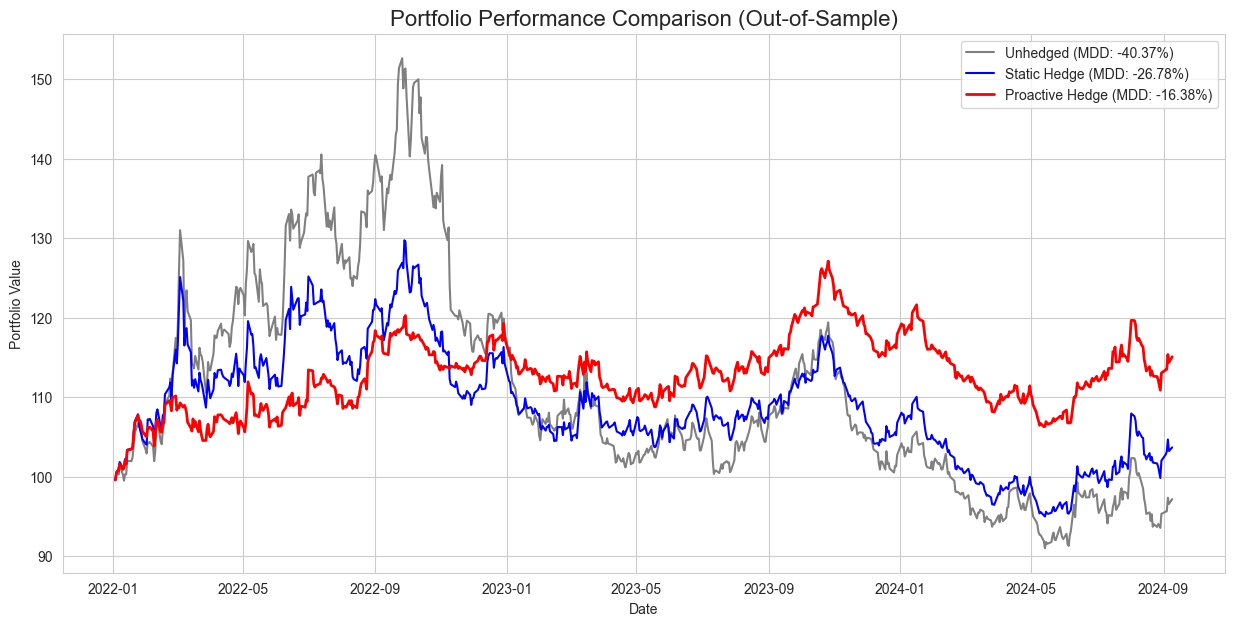


--- Additional Performance Metrics ---
                Annualized Return Annualized Volatility Sharpe Ratio  \
Unhedged                   -1.07%                21.71%        -0.05   
Static Hedge                1.36%                16.61%         0.08   
Proactive Hedge             5.28%                12.12%         0.44   

                Max Drawdown  
Unhedged             -40.37%  
Static Hedge         -26.78%  
Proactive Hedge      -16.38%  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

static_beta = final_data['log returns_y'].cov(final_data['log returns_x']) / final_data['log returns_x'].var()

backtest_df = pd.DataFrame(index=df_test.index)

backtest_df['unhedged_returns'] = df_test['log returns_y']

backtest_df['static_hedge_returns'] = df_test['log returns_y'] - (static_beta * df_test['log returns_x'])

backtest_df['proactive_hedge_returns'] = df_test['log returns_y'] - (results_df['Proactive_Beta'] * df_test['log returns_x'])

initial_capital = 100
equity_curves = initial_capital * np.exp(backtest_df.cumsum())


def calculate_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = drawdown.min()
    return max_drawdown

unhedged_dd = calculate_max_drawdown(equity_curves['unhedged_returns'])
static_dd = calculate_max_drawdown(equity_curves['static_hedge_returns'])
proactive_dd = calculate_max_drawdown(equity_curves['proactive_hedge_returns'])

print("\n--- Backtest Results ---")
print(f"Unhedged Max Drawdown:         {unhedged_dd:.2%}")
print(f"Statically Hedged Max Drawdown: {static_dd:.2%}")
print(f"Proactively Hedged Max Drawdown: {proactive_dd:.2%}")

plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")

plt.plot(equity_curves.index, equity_curves['unhedged_returns'], label=f'Unhedged (MDD: {unhedged_dd:.2%})', color='gray')
plt.plot(equity_curves.index, equity_curves['static_hedge_returns'], label=f'Static Hedge (MDD: {static_dd:.2%})', color='blue')
plt.plot(equity_curves.index, equity_curves['proactive_hedge_returns'], label=f'Proactive Hedge (MDD: {proactive_dd:.2%})', color='red', linewidth=2)

plt.title('Portfolio Performance Comparison (Out-of-Sample)', fontsize=16)
plt.ylabel('Portfolio Value')
plt.xlabel('Date')
plt.legend()
plt.show()

import numpy as np

print("\n--- Additional Performance Metrics ---")

TRADING_DAYS_PER_YEAR = 252

daily_returns = backtest_df

annualized_mean_return = daily_returns.mean() * TRADING_DAYS_PER_YEAR

annualized_volatility = daily_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)

sharpe_ratio = annualized_mean_return / annualized_volatility

performance_summary = pd.DataFrame({
    'Annualized Return': annualized_mean_return,
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio
})

max_drawdowns = {
    'unhedged_returns': unhedged_dd,
    'static_hedge_returns': static_dd,
    'proactive_hedge_returns': proactive_dd
}
performance_summary['Max Drawdown'] = performance_summary.index.map(max_drawdowns)

performance_summary.rename(index={
    'unhedged_returns': 'Unhedged',
    'static_hedge_returns': 'Static Hedge',
    'proactive_hedge_returns': 'Proactive Hedge'
}, inplace=True)

performance_summary['Annualized Return'] = performance_summary['Annualized Return'].apply(lambda x: f"{x:.2%}")
performance_summary['Annualized Volatility'] = performance_summary['Annualized Volatility'].apply(lambda x: f"{x:.2%}")
performance_summary['Max Drawdown'] = performance_summary['Max Drawdown'].apply(lambda x: f"{x:.2%}")
performance_summary['Sharpe Ratio'] = performance_summary['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")

print(performance_summary)